In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm._tqdm as tqdm 
import random
import h3
import folium
from shapely.geometry import Polygon,Point

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9048\2090327623.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.std.*` instead of `tqdm._tqdm.*`
  import tqdm._tqdm as tqdm


In [2]:
df_offers=pd.read_csv('../datasets/data_offers.csv')
df_orders=pd.read_csv('../datasets/data_orders.csv')
df_offers.head(2)


,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651


In [3]:
df_orders.head(2)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0


In [4]:
df_orders['order_status_key'].value_counts()

4    7307
9    3409
Name: order_status_key, dtype: int64

In [166]:
df_orders[(df_orders['order_status_key']==9) & (df_orders['is_driver_assigned_key']==1)]

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,h3_index
1158,16:49:55,-0.974337,51.465422,418.0,3000631256425,9,1,NaN,88195d2b0bfffff
6881,00:44:03,-0.973348,51.453919,60.0,3000630156338,9,1,NaN,88195d2b15fffff
7968,00:12:02,-0.974735,51.454823,298.0,3000600112433,9,1,NaN,88195d2b15fffff


### task 1: Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

In [15]:
order_status_set=df_orders['order_status_key'].unique()
is_driver_assigned_key_set=df_orders['is_driver_assigned_key'].unique()
def mapping(n):
    if n==0:
        return 'no driver'
    elif n==1:
        return 'driver'
    elif n==4:
        return 'client & '
    else:
        return 'system & '

reasons=[]
for i in order_status_set:
    for j in is_driver_assigned_key_set:
        temp_df=df_orders[(df_orders['order_status_key']==i)&(df_orders['is_driver_assigned_key']==j)]
        reasons.append([mapping(i)+mapping(j),len(temp_df)])
reasons


[['client & driver', 2811],
 ['client & no driver', 4496],
 ['system & driver', 3],
 ['system & no driver', 3406]]

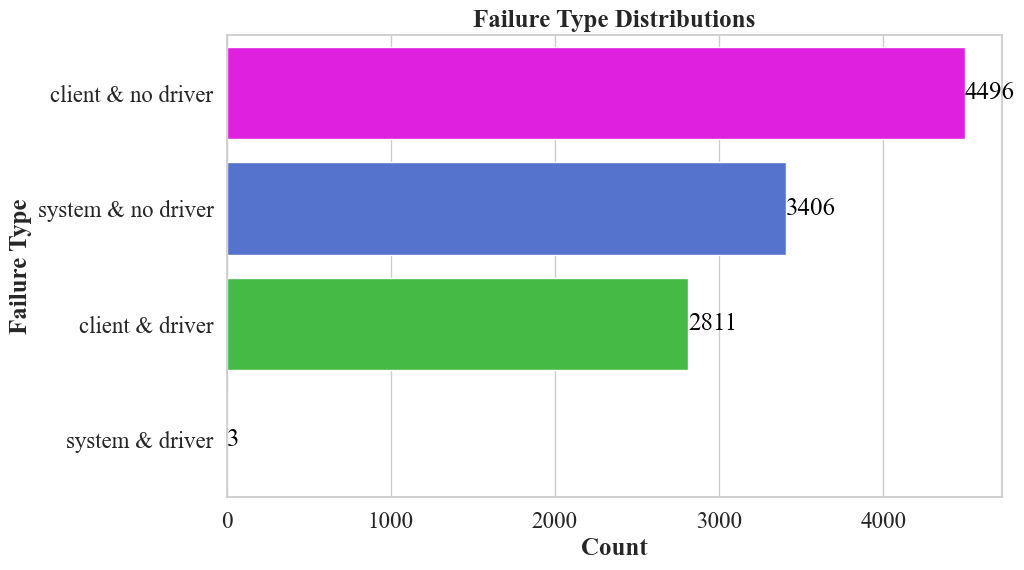

In [37]:
categories = [i[0] for i in reasons]
values = [i[1] for i in reasons]
colors =['fuchsia', 'royalblue', 'limegreen', 'tomato']
categories, values = zip(*sorted(zip(categories, values), key=lambda x: x[1], reverse=True))

sns.set(style="whitegrid", font_scale=1.5, font='Times New Roman')  # Set font to Times New Roman
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(values), y=list(categories), palette=colors, capsize=0.2)  # Make the edges round

# Displaying values on the bars
for i, v in enumerate(values):
    ax.text(v + 0.1, i, str(v), color='black', va='center', fontdict={'family': 'Times New Roman'})

plt.xlabel('Count',fontdict={'family': 'Times New Roman', 'weight': 'bold'})
plt.ylabel('Failure Type',fontdict={'family': 'Times New Roman', 'weight': 'bold'})
# Add title
plt.title('Failure Type Distributions',  fontdict={'family': 'Times New Roman', 'weight': 'bold'})  # Set title font to Times New Roman

# Show plot
plt.show()

In [12]:
list(values)

[4496, 3406, 2811, 3]

the highest failure region is when the driver is not assigned and cancelled by client.

### task 2: Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

In [67]:
hours=['{:02d}'.format(hour) for hour in range(24)]
reasons=[]
for h in hours:
    for i in order_status_set:
        for j in is_driver_assigned_key_set:
            temp_df=df_orders[(df_orders['order_status_key']==i)&
                      (df_orders['is_driver_assigned_key']==j) &
                      (df_orders['order_datetime'].str.startswith(h))]
            reasons.append([h, str(i)+'&'+str(j),len(temp_df)])

In [69]:
# fig, axes = plt.subplots(4, 6, figsize=(18, 12))
# count = 0
# for i in range(4):
#     for j in range(6):
#         index = i * 6 + j
#         ax = axes[i, j]
        
#         if index < 24:
#             sns.barplot(x=[x[1] for x in reasons[count*4:(count+1)*4]], y=[x[2] for x in reasons[count*4:(count+1)*4]], ax=ax)
#             ax.set_title('{:02d}'.format(count)+':00 ~ '+'{:02d}'.format(count+1)+':00')  # 设置子图标题
#             ax.set_xlabel('failure type')  # 设置x轴标签
#             ax.set_ylabel('counts')  # 设置y轴标签
#             sns.despine(ax=ax)  # 移除边框
            
#         else:
#             ax.set_axis_off()  # 如果没有图就关闭轴
#         count += 1

# plt.suptitle('failure types\' distribution by hour', fontsize=16)  # 添加总标题
# plt.tight_layout()
# plt.show()


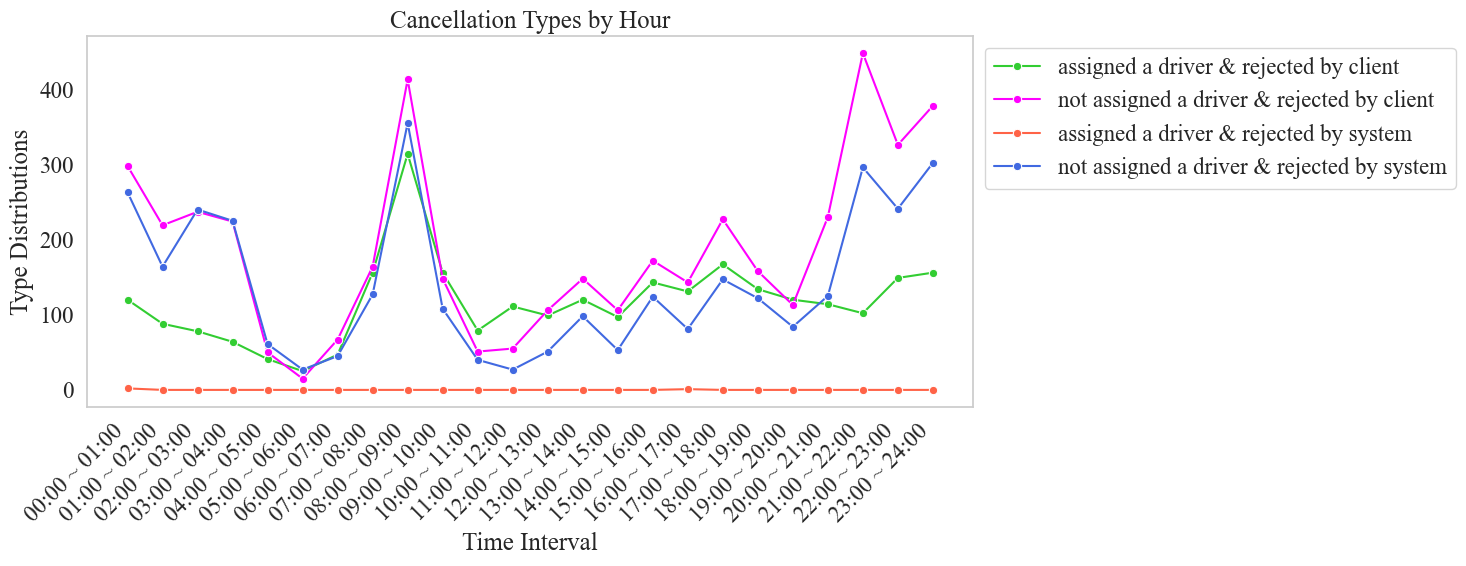

In [70]:
# 数据
x_values = np.arange(24)
y_values1 = [reasons[i*4][2] for i in range(24)]
y_values2 = [reasons[i*4+1][2] for i in range(24)]
y_values3 = [reasons[i*4+2][2] for i in range(24)]
y_values4 = [reasons[i*4+3][2] for i in range(24)]

# 创建图
plt.figure(figsize=(15, 6))
plt.grid(False)
# 绘制平滑曲线并显示点
sns.lineplot(x=x_values, y=y_values1, label='assigned a driver & rejected by client', estimator='mean', marker='o', color='limegreen')
sns.lineplot(x=x_values, y=y_values2, label='not assigned a driver & rejected by client', estimator='mean', marker='o', color='fuchsia')
sns.lineplot(x=x_values, y=y_values3, label='assigned a driver & rejected by system', estimator='mean', marker='o', color='tomato')
sns.lineplot(x=x_values, y=y_values4, label='not assigned a driver & rejected by system', estimator='mean', marker='o', color='royalblue')

# 设置标题和标签
plt.title('Cancellation Types by Hour')
plt.xlabel('Time Interval')
plt.ylabel('Type Distributions')

# 设置x轴刻度标签
hour_labels = ['{:02d}'.format(i)+':00 ~ '+'{:02d}'.format(i+1)+':00' for i in range(24)]
plt.xticks(range(24), hour_labels, rotation=45, ha='right')

# 调整图例位置
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


In [122]:
hour_labels = ['{:02d}'.format(i)+':00 ~ '+'{:02d}'.format(i+1)+':00' for i in range(24)]
reasons=['no driver & client','no driver & system','driver & client','driver & system']
count=[]
driver_01=[0,1]
cilent_49=[4,9]
for i in driver_01:
    for j in cilent_49:
        temp_df=df_orders[(df_orders['is_driver_assigned_key']==i)&
                  (df_orders['order_status_key']==j)]
        temp=[]
        for h in hours:
            temp.append(len(temp_df[temp_df['order_datetime'].str.startswith(h)]))
        count.append(temp)
count

[[298,
  219,
  237,
  224,
  50,
  15,
  67,
  164,
  413,
  148,
  51,
  55,
  106,
  148,
  106,
  172,
  143,
  227,
  158,
  113,
  230,
  448,
  326,
  378],
 [263,
  164,
  240,
  225,
  61,
  27,
  45,
  127,
  355,
  108,
  40,
  27,
  51,
  98,
  53,
  124,
  81,
  147,
  122,
  84,
  125,
  296,
  241,
  302],
 [120,
  88,
  78,
  64,
  41,
  25,
  47,
  156,
  314,
  156,
  79,
  111,
  99,
  120,
  97,
  143,
  131,
  167,
  134,
  120,
  114,
  102,
  149,
  156],
 [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]

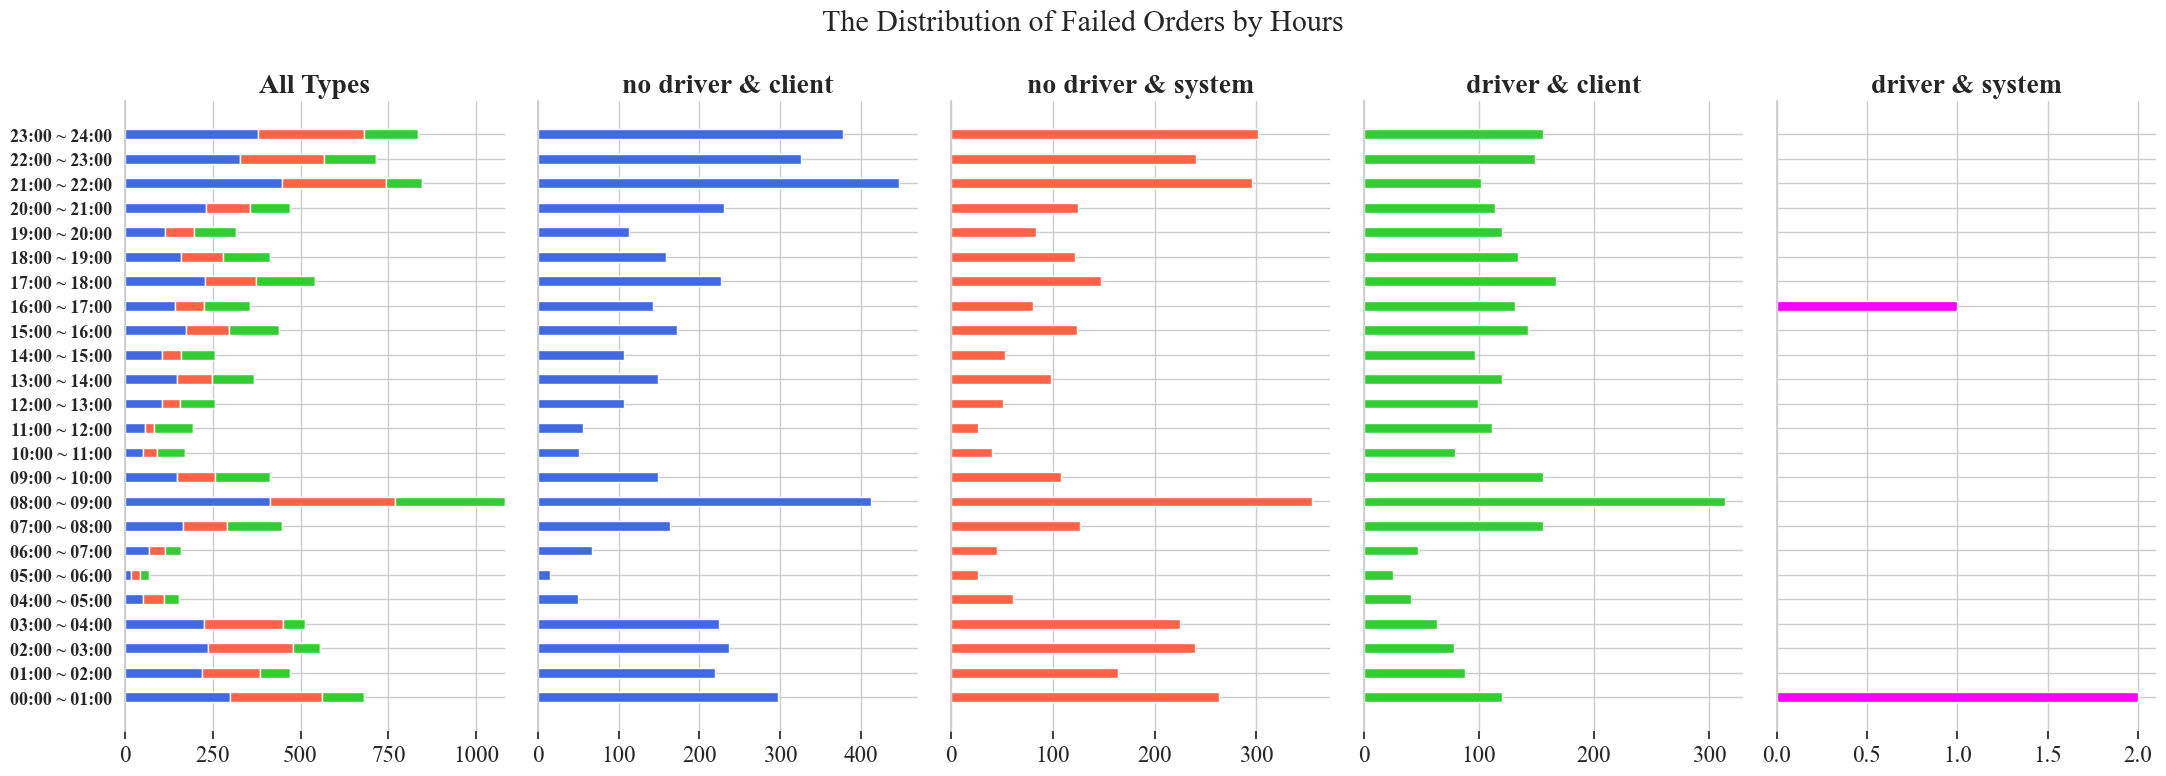

In [136]:
# 创建图形和子图
categories=hour_labels
values=count
reasons=reasons
fig, axes = plt.subplots(1, 5, figsize=(22, 8), sharey=True)

bottom = np.zeros(len(categories))
for i in range(4):
    bars = axes[0].barh(np.arange(len(categories)), values[i], height=0.4, color=colors[i], left=bottom)
    bottom += values[i]

# 设置堆叠图的标题和样式
axes[0].set_title('All Types', fontweight='bold', fontsize=20, fontname='Times New Roman')
axes[0].set_yticks(np.arange(len(categories)))
axes[0].set_yticklabels(categories, fontweight='bold', fontsize=13, fontname='Times New Roman')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(True)
axes[0].xaxis.set_visible(True)  # 显示 x 轴
axes[0].xaxis.set_ticks_position('bottom')
axes[0].tick_params(axis='x', which='both', bottom=True)  # 设置 x 轴刻度线

# 绘制原始四个子图
for i in range(4):
    bars = axes[i+1].barh(np.arange(len(categories)), values[i], height=0.4, color=colors[i])
    axes[i+1].set_title(reasons[i], fontweight='bold', fontsize=20, fontname='Times New Roman')
    axes[i+1].set_yticks(np.arange(len(categories)))
    axes[i+1].set_yticklabels(categories, fontweight='bold', fontsize=13, fontname='Times New Roman')
    axes[i+1].spines['top'].set_visible(False)
    axes[i+1].spines['right'].set_visible(False)
    axes[i+1].spines['bottom'].set_visible(False)
    axes[i+1].spines['left'].set_visible(True)
    axes[i+1].xaxis.set_visible(True)  # 显示 x 轴
    axes[i+1].xaxis.set_ticks_position('bottom')
    axes[i+1].tick_params(axis='x', which='both', bottom=True)  # 设置 x 轴刻度线

# 设置整体图标题
plt.suptitle('The Distribution of Failed Orders by Hours',fontdict={'fontname': 'Times New Roman'})

plt.tight_layout(rect=[0, 0.00, 1, 1])  # 调整布局以适应标题
plt.show()



it can be seen during 09:00~12:00, 19:00~20:00 the ratio of getting a failure with 4 & 1 is much higher,and during midnight, 9 & 0 failure type happens more frequetly, this may due to the fact that there's few deivers still working at that time. the most abnormal time is 05:00~06:00, where the failure type 4&1 are smaller than 4&1 and 9&1

### Task 3: Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

In [208]:
def remove_outliers(arr):
    mean_value = np.nanmean(arr)
    std_dev = np.nanstd(arr)
    threshold = 3 * std_dev
    cleaned_arr = [x for x in arr if abs(x - mean_value) <= threshold]
    return cleaned_arr

temp=0
hours=['{:02d}'.format(hour) for hour in range(24)]
average_time=[]
for h in hours:
    for j in is_driver_assigned_key_set:
        temp_df=df_orders[(df_orders['is_driver_assigned_key']==j) &
                    (df_orders['order_datetime'].str.startswith(h))]
        temp=temp_df
        average_time.append([h, str(j),np.average(remove_outliers(temp_df['cancellations_time_in_seconds'])), remove_outliers(np.array(temp_df['cancellations_time_in_seconds']))])
average_time

[['00',
  '1',
  281.0840336134454,
  [316.0,
   30.0,
   312.0,
   323.0,
   244.0,
   57.0,
   435.0,
   223.0,
   29.0,
   123.0,
   215.0,
   257.0,
   182.0,
   304.0,
   112.0,
   227.0,
   262.0,
   200.0,
   47.0,
   442.0,
   165.0,
   38.0,
   116.0,
   31.0,
   1075.0,
   111.0,
   565.0,
   158.0,
   564.0,
   473.0,
   944.0,
   392.0,
   109.0,
   72.0,
   547.0,
   46.0,
   47.0,
   72.0,
   36.0,
   65.0,
   74.0,
   47.0,
   127.0,
   576.0,
   716.0,
   82.0,
   445.0,
   211.0,
   93.0,
   25.0,
   17.0,
   182.0,
   659.0,
   28.0,
   245.0,
   22.0,
   38.0,
   156.0,
   289.0,
   108.0,
   90.0,
   41.0,
   110.0,
   49.0,
   211.0,
   235.0,
   399.0,
   114.0,
   996.0,
   841.0,
   612.0,
   237.0,
   1146.0,
   1112.0,
   61.0,
   258.0,
   311.0,
   78.0,
   36.0,
   269.0,
   424.0,
   206.0,
   150.0,
   517.0,
   777.0,
   270.0,
   262.0,
   36.0,
   19.0,
   838.0,
   679.0,
   136.0,
   1210.0,
   956.0,
   33.0,
   87.0,
   222.0,
   76.0,
   35.0,
   

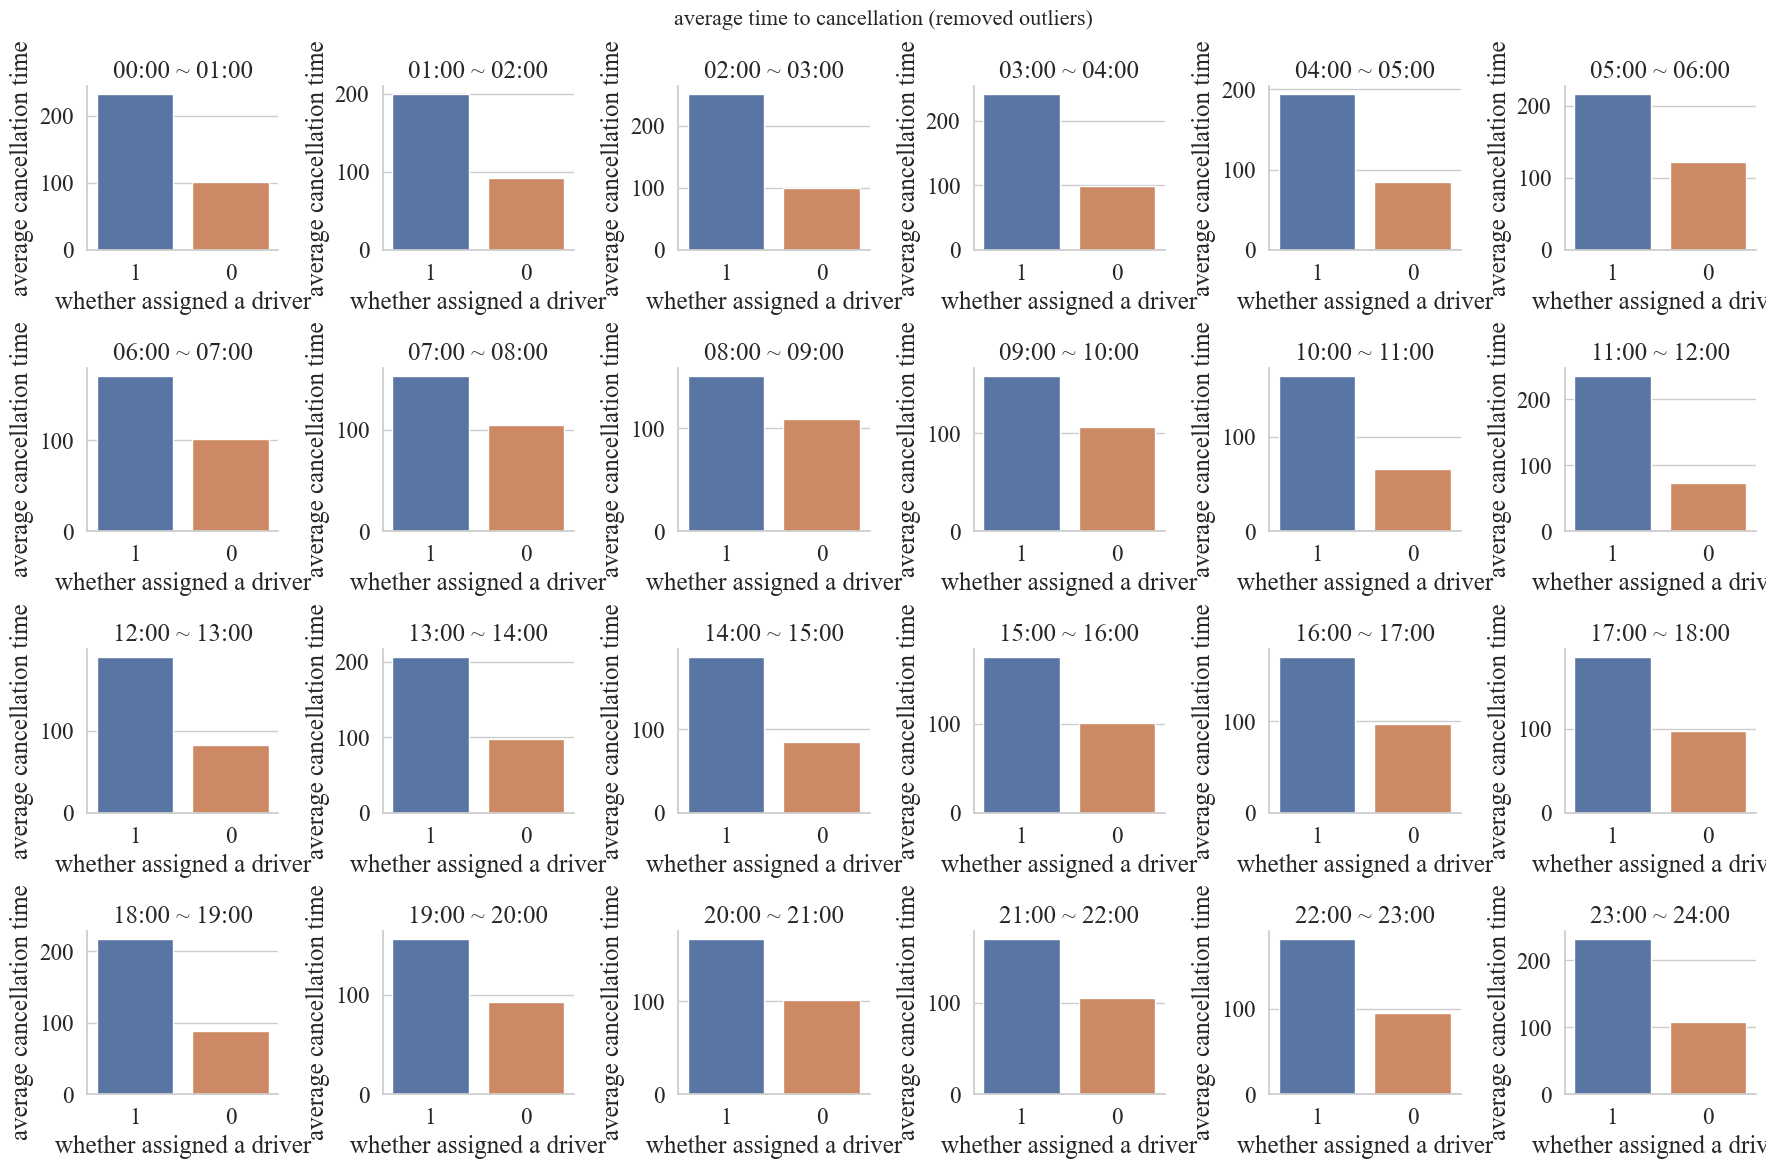

In [138]:
fig, axes = plt.subplots(4, 6, figsize=(18, 12))
count = 0
for i in range(4):
    for j in range(6):
        index = i * 6 + j
        ax = axes[i, j]
        
        if index < 24:
            sns.barplot(x=[x[1] for x in average_time[count*2:(count+1)*2]], y=[x[2] for x in average_time[count*2:(count+1)*2]], ax=ax)
            ax.set_title('{:02d}'.format(count)+':00 ~ '+'{:02d}'.format(count+1)+':00')  # 设置子图标题
            ax.set_xlabel('whether assigned a driver')  # 设置x轴标签
            ax.set_ylabel('average cancellation time')  # 设置y轴标签
            sns.despine(ax=ax)  # 移除边框
            
        else:
            ax.set_axis_off()  # 如果没有图就关闭轴
        count += 1

plt.suptitle('average time to cancellation (removed outliers)', fontsize=16)  # 添加总标题
plt.tight_layout()
plt.show()


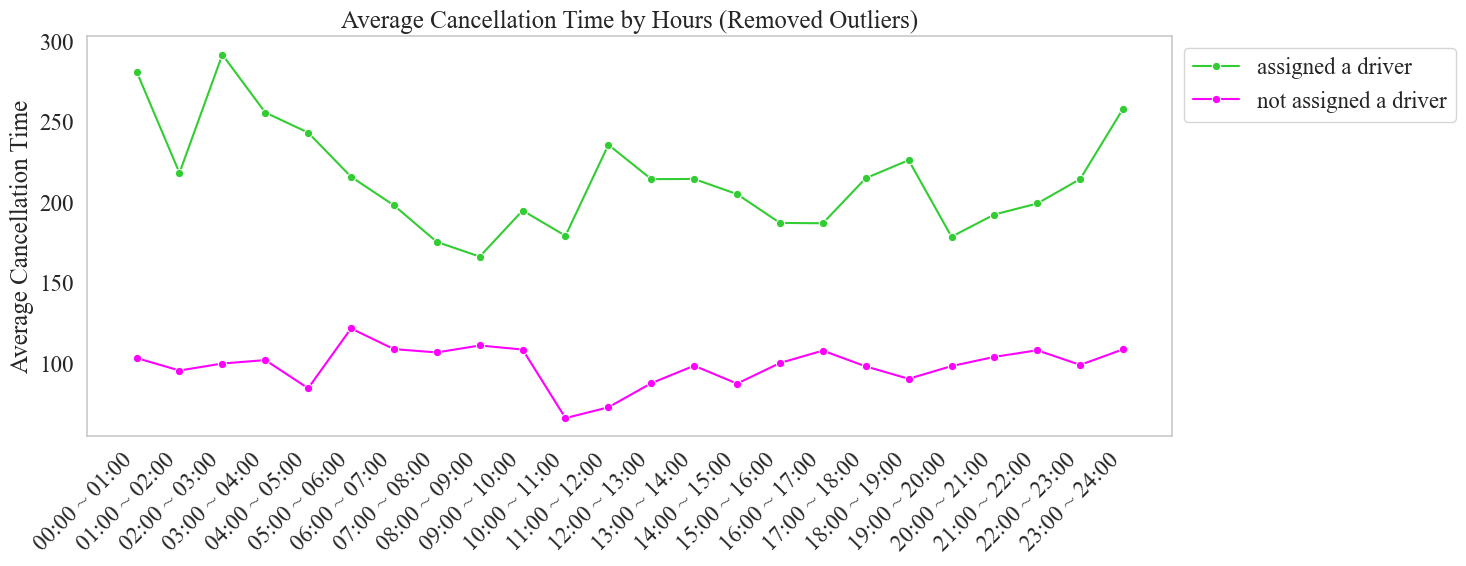

In [209]:
# 数据
x_values = np.arange(24)
y_values1 =  [average_time[i*2][2] for i in range(24)]
y_values2 = [average_time[i*2+1][2] for i in range(24)]


# 创建图
plt.figure(figsize=(15, 6))
plt.grid(False)
# 绘制平滑曲线并显示点
sns.lineplot(x=x_values, y=y_values1, label='assigned a driver', estimator='mean', marker='o', color='limegreen')
sns.lineplot(x=x_values, y=y_values2, label='not assigned a driver', estimator='mean', marker='o', color='fuchsia')


# 设置标题和标签
plt.title('Average Cancellation Time by Hours (Removed Outliers)')
plt.ylabel('Average Cancellation Time')

# 设置x轴刻度标签
hour_labels = ['{:02d}'.format(i)+':00 ~ '+'{:02d}'.format(i+1)+':00' for i in range(24)]
plt.xticks(range(24), hour_labels, rotation=45, ha='right')

# 调整图例位置
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()


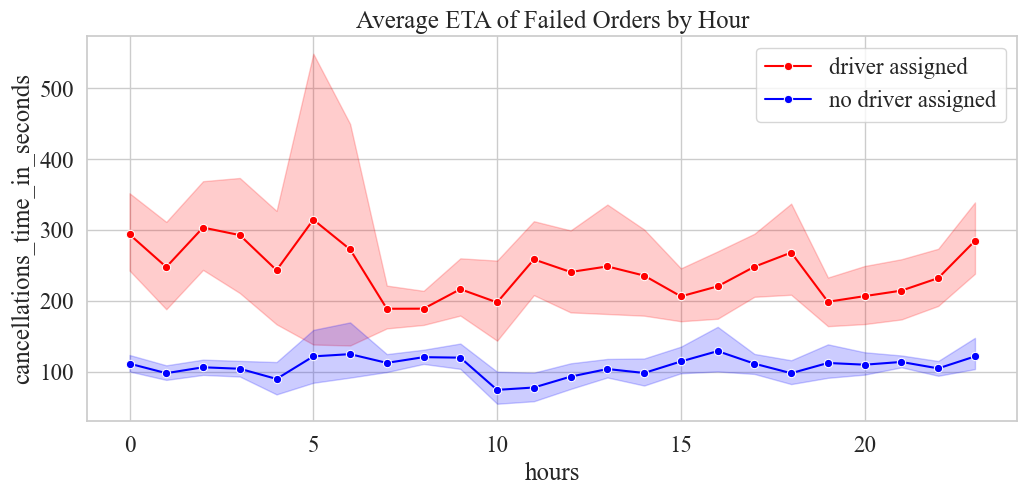

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 df_orders 是你的数据框
df_orders['hours'] = df_orders['order_datetime'].str[0:2].astype(int)
colors1 = ['dodgerblue']*24
colors0 = ['hotpink']*24


plt.figure(figsize=(12,5))

# # 绘制条形图
# sns.barplot(x="hours", y="cancellations_time_in_seconds", data=df_orders[df_orders['is_driver_assigned_key']==1], palette=colors1, dodge=False)
# sns.barplot(x="hours", y="cancellations_time_in_seconds", data=df_orders[df_orders['is_driver_assigned_key']==0], palette=colors0, dodge=False)

plt.title('Average ETA of Failed Orders by Hour')

# 对数据框按照小时进行排序
df_orders_sorted = df_orders.sort_values('hours')

# 添加折线图
sns.lineplot(x="hours", y="cancellations_time_in_seconds", data=df_orders_sorted[df_orders_sorted['is_driver_assigned_key']==1], color='red', marker='o',label='driver assigned')
sns.lineplot(x="hours", y="cancellations_time_in_seconds", data=df_orders_sorted[df_orders_sorted['is_driver_assigned_key']==0], color='blue', marker='o', label='no driver assigned')
plt.legend()
# 显示图形
plt.show()


In [211]:
# np.sum(remove_outliers(df_orders['cancellations_time_in_seconds']))/len(remove_outliers(df_orders['cancellations_time_in_seconds']))
np.sum(df_orders['cancellations_time_in_seconds'])/len(df_orders['cancellations_time_in_seconds'])

107.66302724897349

In [212]:
print(len(remove_outliers(df_orders['cancellations_time_in_seconds'])))
len(df_orders['cancellations_time_in_seconds'])

7163


10716

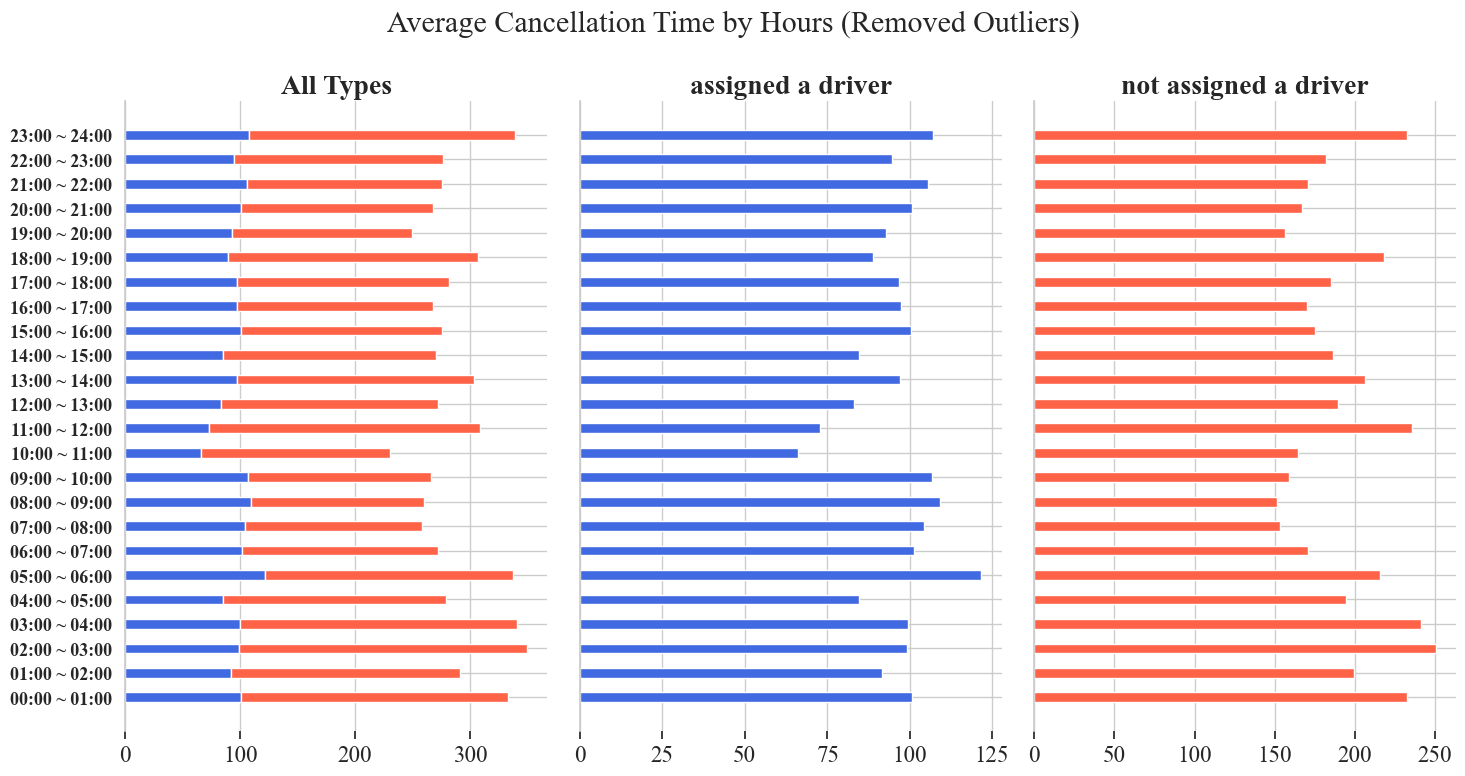

In [163]:
hour_labels = ['{:02d}'.format(i)+':00 ~ '+'{:02d}'.format(i+1)+':00' for i in range(24)]
reasons=['assigned a driver','not assigned a driver']
count=[]
driver_01=[0,1]
# cilent_49=[4,9]
for i in driver_01:
        temp_df=df_orders[(df_orders['is_driver_assigned_key']==i)]
        temp=[]
        for h in hours:
            temp.append(np.mean(remove_outliers((temp_df[temp_df['order_datetime'].str.startswith(h)]['cancellations_time_in_seconds']))))
        count.append(temp)
count

categories=hour_labels
values=count
reasons=reasons
fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharey=True)

# 创建堆叠图，将其放在第一个子图位置
import matplotlib.pyplot as plt
import numpy as np

# 假设你已经定义了 categories、values、reasons 和 colors

bottom = np.zeros(len(categories))
for i in range(2):
    bars = axes[0].barh(np.arange(len(categories)), values[i], height=0.4, color=colors[i], left=bottom)
    bottom += values[i]

# 设置堆叠图的标题和样式
axes[0].set_title('All Types', fontweight='bold', fontsize=20, fontname='Times New Roman')
axes[0].set_yticks(np.arange(len(categories)))
axes[0].set_yticklabels(categories, fontweight='bold', fontsize=13, fontname='Times New Roman')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(True)
axes[0].xaxis.set_visible(True)  # 显示 x 轴
axes[0].xaxis.set_ticks_position('bottom')
axes[0].tick_params(axis='x', which='both', bottom=True)  # 设置 x 轴刻度线

# 绘制原始四个子图
for i in range(2):
    bars = axes[i+1].barh(np.arange(len(categories)), values[i], height=0.4, color=colors[i])
    axes[i+1].set_title(reasons[i], fontweight='bold', fontsize=20, fontname='Times New Roman')
    axes[i+1].set_yticks(np.arange(len(categories)))
    axes[i+1].set_yticklabels(categories, fontweight='bold', fontsize=13, fontname='Times New Roman')
    axes[i+1].spines['top'].set_visible(False)
    axes[i+1].spines['right'].set_visible(False)
    axes[i+1].spines['bottom'].set_visible(False)
    axes[i+1].spines['left'].set_visible(True)
    axes[i+1].xaxis.set_visible(True)  # 显示 x 轴
    axes[i+1].xaxis.set_ticks_position('bottom')
    axes[i+1].tick_params(axis='x', which='both', bottom=True)  # 设置 x 轴刻度线

# 设置整体图标题
plt.suptitle('Average Cancellation Time by Hours (Removed Outliers)',fontdict={'fontname': 'Times New Roman'})

plt.tight_layout(rect=[0, 0.00, 1, 1])  # 调整布局以适应标题
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9048\609926247.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.log(x_values1+1), color='blue', shade=True, label='assigned driver')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9048\609926247.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(np.log(x_values0+1), color='red', shade=True, label='not assigned driver')


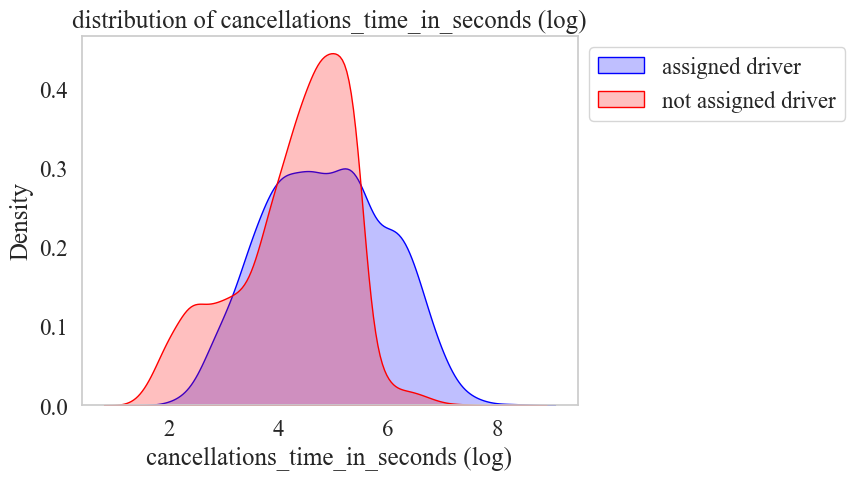

In [151]:
x_values1 = df_orders[df_orders['is_driver_assigned_key']==1]['cancellations_time_in_seconds']
x_values0 = df_orders[df_orders['is_driver_assigned_key']==0]['cancellations_time_in_seconds']

plt.grid(False)
# 创建密度图
sns.kdeplot(np.log(x_values1+1), color='blue', shade=True, label='assigned driver')
sns.kdeplot(np.log(x_values0+1), color='red', shade=True, label='not assigned driver')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 添加标题和标签
plt.title('distribution of cancellations_time_in_seconds (log)')
plt.xlabel('cancellations_time_in_seconds (log)')
plt.ylabel('Density')

# 显示图形
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9048\3668756426.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x_values1, color='blue', shade=True, label='assigned driver')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9048\3668756426.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x_values0, color='red', shade=True, label='not assigned driver')


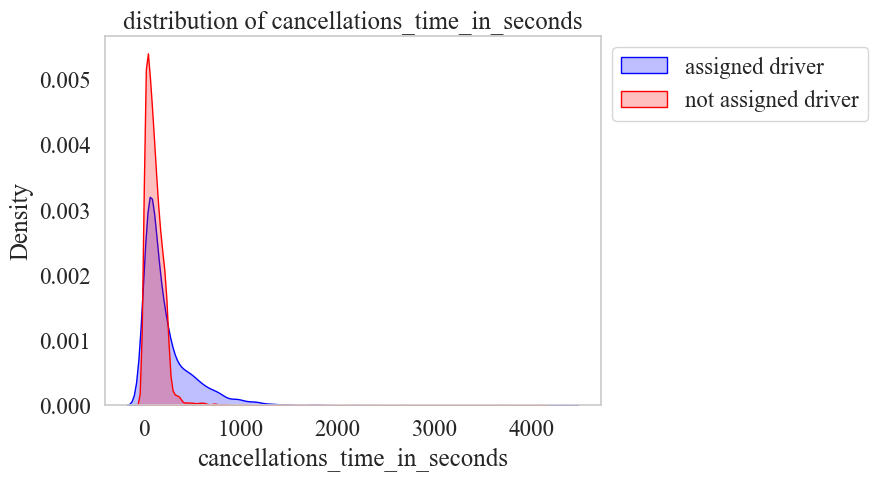

In [164]:
plt.grid(False)
# 创建密度图
sns.kdeplot(x_values1, color='blue', shade=True, label='assigned driver')
sns.kdeplot(x_values0, color='red', shade=True, label='not assigned driver')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# 添加标题和标签
plt.title('distribution of cancellations_time_in_seconds')
plt.xlabel('cancellations_time_in_seconds')
plt.ylabel('Density')

# 显示图形
plt.show()


if a driver is assigned to the client, usually the cancellation time will be much longer (usually 100~120 seconds). if a driver is not assigned, the cancellation time is somehow stable with regard to hours (compared to the situation when the driver is assigned)  
when a driver is assigned, during the midnight and lunch time, clients usually have more patients to wait, however, during the rush hours and evening time, the cancellation time is usually shorter when a driver is assigned.

### task 4: Plot the distribution of average ETA by hours. How can this plot be explained?

In [168]:
hours=['{:02d}'.format(hour) for hour in range(24)]
average_eta=[]
for h in hours:
        temp_df=df_orders[(df_orders['order_datetime'].str.startswith(h))]
        average_eta.append([h, np.mean(temp_df['m_order_eta']),len(temp_df)])
average_eta

[['00', 357.9590163934426, 683],
 ['01', 324.75, 471],
 ['02', 391.0128205128205, 555],
 ['03', 388.09375, 513],
 ['04', 299.6585365853659, 152],
 ['05', 411.12, 67],
 ['06', 427.1489361702128, 159],
 ['07', 583.3589743589744, 447],
 ['08', 636.9108280254777, 1082],
 ['09', 504.89102564102564, 412],
 ['10', 355.55696202531647, 170],
 ['11', 390.9549549549549, 193],
 ['12', 440.7878787878788, 256],
 ['13', 428.025, 366],
 ['14', 387.83505154639175, 256],
 ['15', 454.7902097902098, 439],
 ['16', 440.5681818181818, 356],
 ['17', 519.7425149700599, 541],
 ['18', 419.1865671641791, 414],
 ['19', 369.81666666666666, 317],
 ['20', 300.0964912280702, 469],
 ['21', 333.8529411764706, 846],
 ['22', 372.744966442953, 716],
 ['23', 408.4294871794872, 836]]

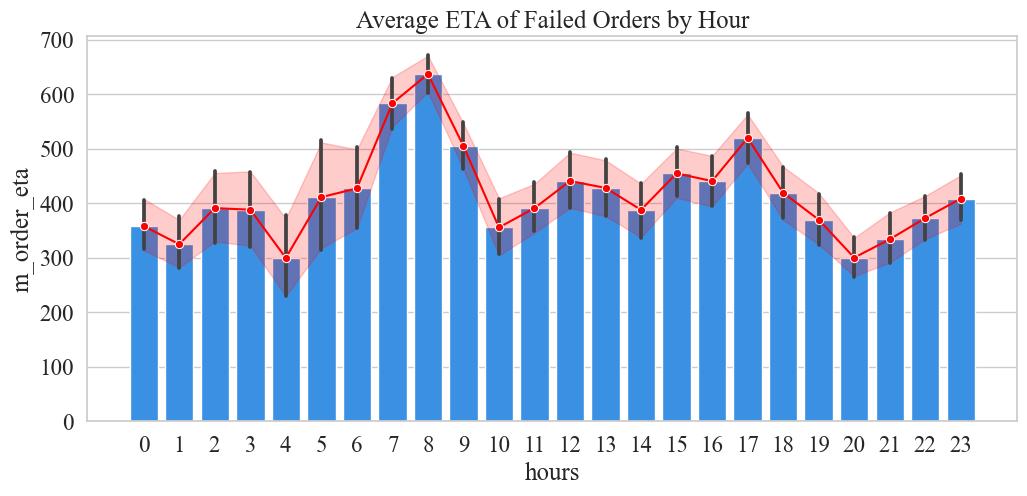

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 df_orders 是你的数据框
df_orders['hours'] = df_orders['order_datetime'].str[0:2].astype(int)
colors = ['dodgerblue']*24

plt.figure(figsize=(12,5))

# 绘制条形图
sns.barplot(x="hours", y="m_order_eta", data=df_orders, palette=colors, dodge=False)
plt.title('Average ETA of Failed Orders by Hour')

# 对数据框按照小时进行排序
df_orders_sorted = df_orders.sort_values('hours')

# 添加折线图
sns.lineplot(x="hours", y="m_order_eta", data=df_orders_sorted, color='red', marker='o')

# 显示图形
plt.show()


In [61]:
np.corrcoef(y_values1[:20],y_values2[:20])

array([[1.        , 0.55006388],
       [0.55006388, 1.        ]])

this implies during the rush hours the waiting time for clients is usually longer, and that having a higher possibility to reject.

### task 4: **BONUS** Hexagons. Using the [h3](https://github.com/uber/h3-py) and [folium](https://python-visualization.github.io/folium/latest/) packages, calculate how many sizes [8 hexes](https://h3geo.org/#/documentation/core-library/resolution-table) contain 80% of all orders from the original data sets and visualize the hexes, coloring them by the number of fails on the map.

In [63]:

def calculate_hexes(df, resolution=8, coverage=0.8):
    # 将经纬度转换为 H3 六边形索引
    df['h3_index'] = df.apply(lambda row: h3.geo_to_h3(row['origin_latitude'], row['origin_longitude'], resolution), axis=1)
    
    # 计算每个 H3 六边形中的订单数
    hex_counts = df['h3_index'].value_counts().sort_values(ascending=False)
    
    # 计算覆盖80%订单的六边形数量
    total_orders = hex_counts.sum()
    target_orders = total_orders * coverage
    accumulated_orders = 0
    hexes_covered = []
    for hex_index, order_count in hex_counts.items():
        accumulated_orders += order_count
        hexes_covered.append(hex_index)
        if accumulated_orders >= target_orders:
            break
    
    # 返回覆盖80%订单的六边形及其订单数
    return hexes_covered

# 计算多边形的面积
def calculate_polygon_area(coords):
    polygon = Polygon(coords)
    return polygon.area

# 可视化六边形并计算六边形面积
def visualize_hexes(hexes, df, map_center=[df_orders['origin_latitude'].mean(), df_orders['origin_longitude'].mean()]):
    # 创建地图
    m = folium.Map(location=map_center, zoom_start=10)
    
    # 计算每个六边形内部的点密度
    hex_density = {}
    for hex_index in hexes:
        hex_boundary = h3.h3_to_geo_boundary(hex_index)
        polygon = Polygon(hex_boundary)
        hex_density[hex_index] = sum(polygon.contains(Point(lat, lon)) for lat, lon in zip(df['origin_latitude'], df['origin_longitude']))
    
    max_density = max(hex_density.values())
    min_density = min(hex_density.values())

    
    colormap = plt.cm.viridis

    for hex_index in hexes:
        density = hex_density[hex_index]
        hex_boundary = h3.h3_to_geo_boundary(hex_index)
        color = colormap((density - min_density) / (max_density - min_density))[:3]  # 使用viridis颜色映射
        color = "#{:02x}{:02x}{:02x}".format(int(color[0]*255), int(color[1]*255), int(color[2]*255)) # Convert to hexadecimal color
        folium.Polygon(locations=hex_boundary, fill_color=color, fill_opacity=0.7, tooltip=f"Hex: {hex_index}<br>Density: {density}").add_to(m)
    

    colormap = [colormap(i) for i in np.linspace(0, 1, 10)]
    gradient_map = folium.LinearColormap(colormap, vmin=min_density, vmax=max_density)
    gradient_map.add_to(m)
    
    # 显示地图
    return m

# 计算覆盖80%订单的H3六边形
hexes_covered = calculate_hexes(df_orders)

# 可视化六边形并计算六边形面积
m = visualize_hexes(hexes_covered, df_orders)
m.save("../outputs/hexes_map.html")
